In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [10]:
input_path_blu = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\blue_images_sample\\final_image9.jpg"
input_path_red = "C:\\Users\\krrah\\Downloads\\Dewinter2023\\Final_yolov5x\\red_images_sample\\final_image25.jpg"

In [31]:
img_blu = cv2.imread(input_path_blu)
img_blu_copy = img_blu.copy()
img_red = cv2.imread(input_path_red)
img_red_copy = img_red.copy()

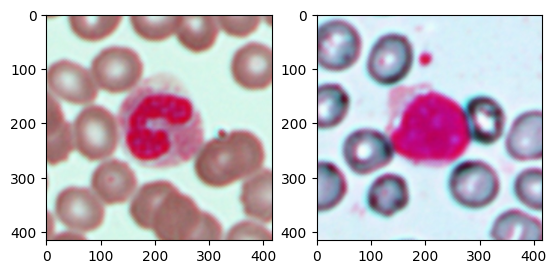

In [32]:
plt.subplot(121)
plt.imshow(img_blu)
plt.subplot(122)
plt.imshow(img_red)

In [33]:
# Define the RGB to CMYK conversion function
def select_center_contour(contours):
    if len(contours) == 0:
        return None

    # Compute the areas of all contours
    contour_areas = [cv2.contourArea(contour) for contour in contours]

    # Find the index of the contour with the largest area
    max_area_index = np.argmax(contour_areas)

    # Return the contour with the largest area
    center_contour = contours[max_area_index]

    return center_contour


def bgr_to_cmyk(bgr):
    b, g, r = bgr/255.0
    b, g, r = b/255.0, g/255.0, r/255.0
    k = 1 - np.max([b, g, r])
    if k == 1:
        c = m = y = 0
    else:
        c = (1 - r - k) / (1 - k)
        m = (1 - g - k) / (1 - k)
        y = (1 - b - k) / (1 - k)
    return np.array([c, m, y, k])


def smooth_contour(contour, epsilon):
    # Convert the contour to a numpy array
    contour = np.squeeze(contour)

    # Reshape the contour to fit the required format for cv2.approxPolyDP
    contour = contour.reshape((-1, 1, 2))

    # Apply the Douglas-Peucker algorithm for contour approximation
    smoothed_contour = cv2.approxPolyDP(contour, epsilon, True)

    return smoothed_contour

(416, 416, 4)


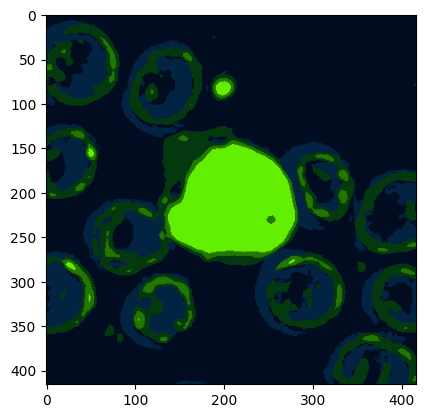

In [34]:
# Apply the RGB to CMYK conversion to each pixel using a lambda function
cmyk_img = np.apply_along_axis(
    lambda x: bgr_to_cmyk(x), axis=2, arr=img_red)
cmyk_img_copy = cmyk_img.copy()
# plt.imshow(cmyk_img)
# Scale the values in the CMYK image to the range 0-255
cmyk_img = (cmyk_img*255).astype(np.uint8)

pixels = cmyk_img.reshape(-1, 4)
pixels = np.float32(pixels)
# Define the criteria for K-means clustering (maximum iterations and epsilon)
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 100, 0.9)

# Perform K-means clustering
k = 5  # Number of clusters
_, labels, centers = cv2.kmeans(
    pixels, k, None, criteria, 100, cv2.KMEANS_RANDOM_CENTERS)

# Convert the centers to unsigned integers
centers = np.uint8(centers)
# Map the labels to the centers
segmented_image = centers[labels.flatten()]

# Reshape the segmented image back to the original shape
segmented_image_red = segmented_image.reshape(cmyk_img.shape)
plt.imshow(segmented_image_red)
print(segmented_image_red.shape)

(416, 416, 3)


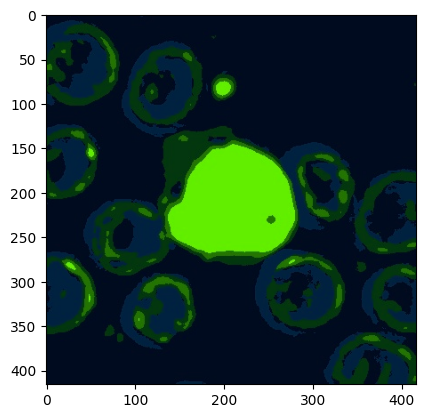

In [35]:
cv2.imwrite("segmented_image_red.jpg", segmented_image_red)
# Apply the RGB to CMYK conversion to each pixel using a lambda function
bgr_img = cv2.imread("segmented_image_red.jpg")
plt.imshow(bgr_img)
print(bgr_img.shape)

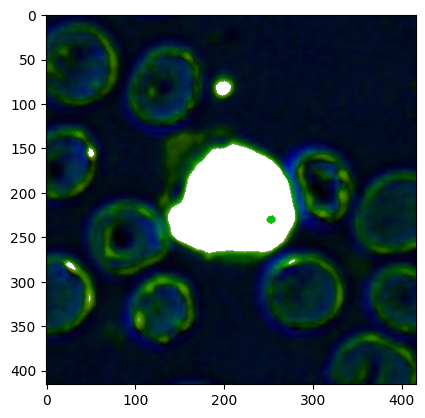

In [42]:
segmented_HSV = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
# plt.imshow(segmented_HSV)
segmented_image_gray = cv2.cvtColor(segmented_image_red, cv2.COLOR_BGR2GRAY)
# Set the threshold value (adjust as needed)

_, segmented_mask = cv2.threshold(
    segmented_image_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
# Invert the binary image using bitwise_not()
inverted_image = cv2.bitwise_not(segmented_mask)
contours, _ = cv2.findContours(
    inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = select_center_contour(contours)
cv2.drawContours(img_red_copy, [contours], -1, (0, 0, 255), 3)
segmented_result = cv2.bitwise_and(
    cmyk_img_copy, cmyk_img_copy, mask=segmented_mask)


mask = np.zeros(segmented_mask.shape[:2], dtype="uint8")

contour_portion = cv2.bitwise_and(
    segmented_mask, segmented_mask, mask=mask)
plt.imshow(segmented_result)

In [47]:
L, A, B = cv2.split(segmented_HSV)
# plt.imshow(L)
# Apply thresholding to the CLAHE transformed image
kernel = np.ones((3, 3), np.uint8)
_, thresholded_image = cv2.threshold(L, 30, 255, cv2.THRESH_BINARY)

# Define the kernel for erosion and dilation
kernel = np.ones((5, 5), np.uint8)
# cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
segmented_mask = cv2.erode(thresholded_image, kernel, iterations=2)
segmented_mask = cv2.morphologyEx(
    segmented_mask, cv2.MORPH_OPEN, kernel, iterations=1)

contours, _ = cv2.findContours(
    segmented_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = select_center_contour(contours)
contour_areas = [cv2.contourArea(contour) for contour in contours]

# Find the index of the contour with the largest area
max_area_index = np.argmax(contour_areas)
# Choose the index of the contour you want to smoothen
contour_perimeter = cv2.arcLength(contours[max_area_index], True)
contour_area = contour_areas[max_area_index]
# Set the epsilon value for contour smoothing (adjust as needed)
epsilon = 0.009 * cv2.arcLength(contours[max_area_index], True)
smooth_contours = smooth_contour(contours, epsilon)
# contours = cv2.convexHull(contours)
cv2.drawContours(img_red_copy, [smooth_contours], -1, (0, 255, 0), 3)
cv2.putText(img_red_copy, f"Area: {contour_area}", (
    smooth_contours[0][0][0], smooth_contours[0][0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
cv2.putText(img_red_copy, f"Perimeter: {contour_perimeter}", (
    smooth_contours[0][0][0], smooth_contours[0][0][1] + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

array([[[221, 237, 249],
        [221, 237, 249],
        [221, 237, 249],
        ...,
        [221, 234, 250],
        [223, 233, 251],
        [223, 233, 251]],

       [[221, 237, 249],
        [221, 237, 249],
        [221, 237, 249],
        ...,
        [221, 234, 250],
        [223, 233, 251],
        [222, 232, 250]],

       [[223, 236, 250],
        [223, 236, 250],
        [223, 237, 249],
        ...,
        [219, 234, 250],
        [220, 232, 250],
        [220, 232, 250]],

       ...,

       [[232, 243, 251],
        [231, 242, 250],
        [231, 242, 250],
        ...,
        [158, 109, 141],
        [162, 114, 142],
        [162, 115, 141]],

       [[231, 244, 252],
        [230, 243, 251],
        [229, 242, 250],
        ...,
        [158, 112, 141],
        [163, 118, 144],
        [164, 120, 143]],

       [[230, 246, 253],
        [229, 245, 252],
        [230, 243, 251],
        ...,
        [159, 113, 142],
        [162, 120, 143],
        [163, 122, 143]]

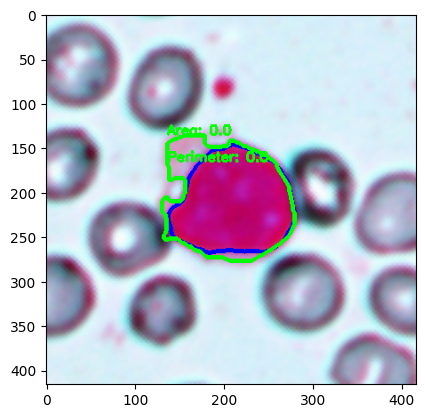

In [48]:
plt.imshow(img_red_copy)